# this was code to fit KES with only intersting peaks selected
overall I don't think this worked, nor do i think this was a good idea :(

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PyCrystalField as cef
import scipy
from scipy.optimize import minimize
from scipy.optimize import leastsq
import pandas as pd
import os


plt.ion()

 *******************************************************
 *                PyCrystalField 2.3.9                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



# first we define some global variables & starting guesses
weights for the stevens operators, from  https://journals.aps.org/prb/pdf/10.1103/PhysRevB.101.144432

In [2]:
# weights for the stevens operators, from 
B20 = -2.773e-2
B40 = -3.987e-4
B43 = -1.416e-2
B60 = 3.152e-6
B63 = -7.616e-6
B66 = 3.275e-5

muB = 5.7883818012e-2  # meV/T
mu0 = np.pi*4e-7       # T*m/A
kB  = 8.617e-2         # [meV/K];
meVToCm =meVTocCmInv= 8.066 
ion = 'Er3+'

# next, let's import the data and take a look
here, we've got two data sets: the actual, processed data (we can talk about data processing some other time) and the selected peak positions
I'm sending you the code with the peak fitting because that is quite a bit simpler and easier to work with


In [ ]:
# full data
fname = '/Users/hopeless/Desktop/LeeLab/data/IR_MagLab_Feb2024/KErSe2Norm0Field.txt' # here put in your own filepath
rawData = pd.read_csv(fname, index_col=0,  header=0, delimiter = '\t')
normDataB = rawData.dropna(axis = 0)
normDataB = 2-normDataB
normDataB = normDataB.drop(labels = 16.995, axis=0)

for col in normDataB.columns: # this step can be done because I'm looking at a diff spec - anything negative i jsut dont care about
    for idx in normDataB.index: 
        if normDataB.loc[idx,col]<0.2: 
            normDataB.loc[idx,col] = 0


Bfield = float(normDataB.columns.values)
wavenums = float(normDataB.index.values)

plt.contourf(Bfield, wavenums, normDataB.T, 100, cmap = 'inferno')
plt.colorbar()
plt.clim(.13,.7)

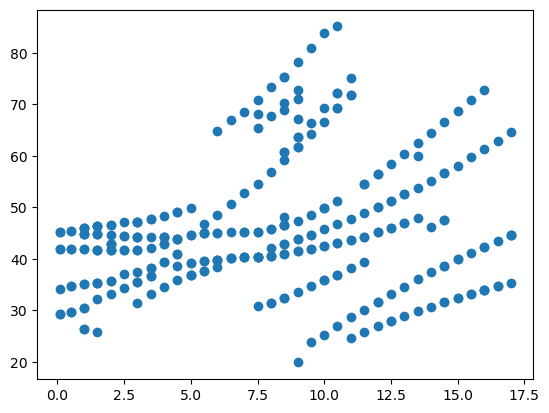

In [41]:
# simplified peak data
fname = '/Users/hopeless/Desktop/LeeLab/data/IR_MagLab_Feb2024/KES_CEF_Peaks.txt' # here put in your own filepath
peakField = np.loadtxt(fname, skiprows= 1, delimiter ='\t', usecols=1)
peakWave = np.loadtxt(fname, skiprows= 1, delimiter ='\t', usecols=0)

plt.scatter(peakField, peakWave)

# now lets define the functions we'll need

In [46]:
# cheaper to define gaussian this way
def gaussian(x, amp,cen , wid):
    return amp * np.exp(-(x-cen)**2 / wid)

# this is just looking at B||a. This is because its a lot less expensive to just calculate B||a
# and if that's where our data is, who cares? I can define other fun for other orientations later
def diagonalize(ionObj, ion, Field): 
    # J.B = ugBJ
    JdotB = muB*(Field*cef.Operator.Jx(ionObj.J))*cef.LandeGFactor(ion) 
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0) # weird code quirk
    ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag
    return ionObj.eigenvalues 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# now we want to build a function that gives us and expected spectrum for each B val
def zeemanSplit(field, wave, B20, B40, B43, B60, B63, B66):     
    # assuming only H||a rn
    # assuming only single field
    Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionObj = cef.CFLevels.Bdict(ion,Bparams)
    evals = diagonalize(ionObj, ion, field)
    centers = evals*meVToCm
    # so now we want to create a multi gaussian with centers at the eigenvalues
    amp = .6
    wid = 1 # pulled this out my ass, .5cm-1 resolution roughly
    fun = gaussian(wave, amp, centers[0], wid)
    for i in range(len(centers[1:])):
        fun += gaussian(wave, amp, centers[i], wid)
    return fun

def costFun(params): 
    # we want to go through each peak we found and calculate a residual
    B20, B40, B43, B60, B63, B66 = params
    chi2=0
    Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionObj = cef.CFLevels.Bdict(ion,Bparams)
    for i in range(len(peakField)): # this is slightly slow but whatever :(
        lines = diagonalize(ionObj, ion, peakField[i])
        lines = lines[2:9] # remove the lines we won't see
        closestLine = find_nearest(lines, peakWave[i])
        chi2 += (peakWave[i]-closestLine)**2/closestLine
        
    #     calc = zeemanSplit(peakField[i], peakWave[i], B20, B40, B43, B60, B63, B66)
    #     obs = 2 # for now, I'm assigning equal peak weight. should I ? probs not but it'll work for testing
    #     chi2 += (obs-calc)**2/calc
        
    return chi2

def fun(x, y, B20, B40, B43, B60, B63, B66):
    arr = []
    for field in x: 
        arr.append(zeemanSplit(field, y, B20, B40, B43, B60, B63, B66))
    return arr

In [47]:
params = [B20, B40, B43, B60, B63, B66]
costFun(params) # quick test to see if our chi2 (the cost) makes sense

47773.768164967776

# so now let's actually do some fitting
for stupid technical (and probably fixable) reasons, I can't use premade fitting packages, like lmfit
so instead, we created a cost function (costFun) - in this case based on chi2, and are minimizing the ***cost*** of our model fit
I'm chooisng the L-BFGS-B method for minimization for technical reasons

In [48]:
result = minimize(costFun, params, method = 'BFGS')

In [49]:
print(result)
print(params)
print(result.x)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 314.39582463630126
        x: [-2.773e-02 -6.194e-04 -1.419e-02  4.402e-05  2.785e-04
            -1.793e-03]
      nit: 4
      jac: [ 4.447e+02  3.542e+04  8.539e+02  2.275e+06  5.554e+04
            -2.468e+05]
 hess_inv: [[ 1.000e+00  6.421e-03 ... -4.860e-03  5.302e-04]
            [ 6.421e-03  1.650e-04 ...  5.329e-04  2.455e-04]
            ...
            [-4.860e-03  5.329e-04 ...  2.595e-03  1.101e-03]
            [ 5.302e-04  2.455e-04 ...  1.101e-03  4.738e-04]]
     nfev: 444
     njev: 62
[-0.02773, -0.0003987, -0.01416, 3.152e-06, -7.616e-06, 3.275e-05]
[-2.77262856e-02 -6.19375709e-04 -1.41884279e-02  4.40220768e-05
  2.78517978e-04 -1.79277327e-03]


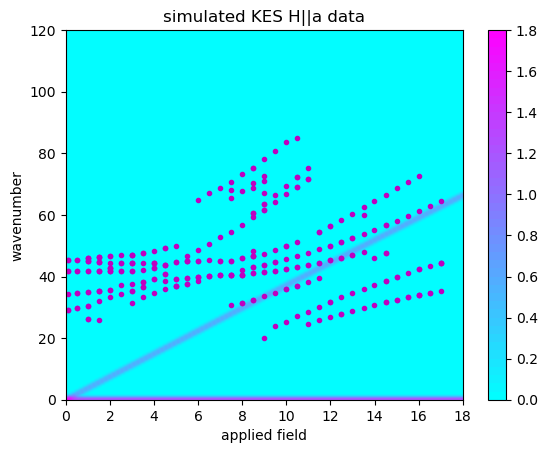

In [50]:
fieldArr = np.linspace(0,18, 100)
waveArr = np.linspace(0,120,1000)
arr = fun(fieldArr, waveArr,result.x[0],result.x[1],result.x[2],result.x[3],result.x[4],result.x[5]) 
arr = np.array(arr)

 
plt.contourf(fieldArr,waveArr,arr.T, 50, cmap='cool')
# plt.xlim(0,17.5)
# plt.ylim(0,120)
# plt.clim(0,.6)
plt.title('simulated KES H||a data')
plt.xlabel('applied field')
plt.ylabel('wavenumber')
plt.colorbar()
plt.scatter(peakField, peakWave, marker = '.', c='m')

# So now you can see that the fit is quite bad
this is mostly because we
    a. can't distiguish CEF/phonon/magnon lines 
    b. can't handle hybridization

# let's plot these lines on the real data